# Survival Analysis

In this notebook, Breast Cancer (METABRIC) dataset is used for the analysis. It consists of clinical profiles of 2,509 breast cancer patients, time period between diagnosis and death, and time period between diagnosis and relapse.

# Main objective

This project have general idea obtain the Kaplan-Meier curves for each tumor stages and compare the results with common sense:

**People with tumor stage more advanced have lower time to survival than people that tumor stage is lower.**

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
!pip install lifelines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [57]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/final_project_IBM/data.csv')

df = data.copy()

In [58]:
df.rename({'Age at Diagnosis': 'init_age', 'Overall Survival (Months)': 'time',
          'Overall Survival Status': 'target', 'Tumor Size': 'tumor_size',
          'Tumor Stage': 'tumor_stage'}, axis=1, inplace=True)

In [59]:
columns = ['init_age', 'time', 'tumor_size', 'tumor_stage', 'target']

df = df[columns]

In [60]:
df.head()

,init_age,time,tumor_size,tumor_stage,target
0,75.65,140.500000,22.0,2.0,Living
1,43.19,84.633333,10.0,1.0,Living
2,48.87,163.700000,15.0,2.0,Deceased
3,47.68,164.933333,25.0,2.0,Living
4,76.97,41.366667,40.0,2.0,Deceased


# Variables for modeling:

* init_age: Age initial when cancer was found;
* time: The Time of observation of people (in months);
* tumor_size: Size of tumor;
* tumor_stage: Stage of tumor (0, 1, 2, 3, 4);
* target: If patient was died (1) or not died (0) in observation time.

In [61]:
# converting target to numeric values
import numpy as np

df['target'] = np.where(df.target == 'Living', 1, 0)

In [62]:
# info of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2509 entries, 0 to 2508
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   init_age     2498 non-null   float64
 1   time         1981 non-null   float64
 2   tumor_size   2360 non-null   float64
 3   tumor_stage  1788 non-null   float64
 4   target       2509 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 98.1 KB


In [63]:
# drop NaN values
df.dropna(inplace=True)

In [64]:
# change type
df = df.astype(int)

In [65]:
# order by time
df.sort_values('time', inplace=True)

Let's filter in some dataframes by tumor stage for construct the survival analysis for each stage of tumor. But, because that the quantity of data for stage 0 and 4, this stages not be considered.

In [66]:
tumor_stages = [1, 2, 3]

dfs = {}

for stage in tumor_stages:
    dfs.update({stage: df[df['tumor_stage'] == stage]})

Creation for each tumor stage the curve of probabilities os survival.

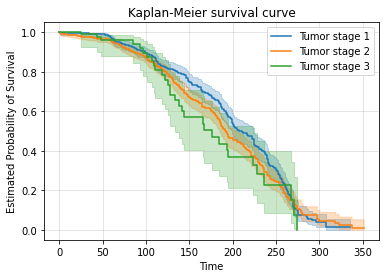

In [67]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

for dataframe in dfs.keys():
    df_stage = dfs[dataframe]

    kmf = KaplanMeierFitter()
    kmf.fit(durations=df_stage['time'], event_observed=df_stage['target'])

    kmf.plot_survival_function(label=f'Tumor stage {dataframe}', title='Kaplan-Meier survival curve',
                               xlabel='Time', ylabel='Estimated Probability of Survival')
    plt.grid(alpha=0.4)

plt.show()

This plot show that in more advanced tumor stages the probability of survived decrease (how expected).

In the stage 3 the probabiliy of suvived decrease to zero before other stages (how exptected).

At aproximately 100 months the behaviour of thre stages is the same, but after this time, stage 3 appear more agressive and the probability of suvival decrease more rapidly than others.

# Other analysis

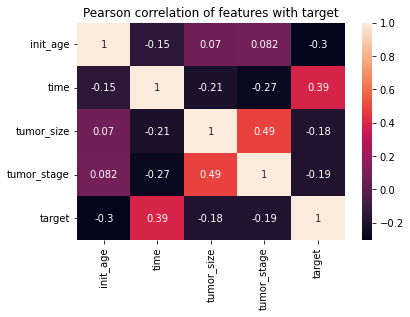

In [68]:
import seaborn as sns

sns.heatmap(df.corr(), annot=True)
plt.title('Pearson correlation of features with target')
plt.show()

* Init age have -0.3 correlation with target, that is, lower values of ages (young people) increase the value of target.

* Time have 0.39 correlation with target, that is, high value of time increase the value of target (it's because when more advanced stage of tumor, more agressive it's).

* Tumor stage have high correlation with tumor size. Thus, for modeling, we use only tumor stage.

In [69]:
# split data
from sklearn.model_selection import train_test_split

x = df[['time', 'init_age', 'tumor_stage']]
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Classifier

In [70]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

models = {
    'logreg': LogisticRegression(),
    'tree': DecisionTreeClassifier(),
    'knn': KNeighborsClassifier(),
    'forest': RandomForestClassifier()
}

results = {}

for i in models.keys():

    model = models[i]
    model.fit(x_train, y_train)

    pred_train = model.predict(x_train)
    pred_test = model.predict(x_test)

    precision_train = round(metrics.precision_score(y_train, pred_train), 2)
    precision_test = round(metrics.precision_score(y_test, pred_test), 2)

    recall_train = round(metrics.recall_score(y_train, pred_train), 2)
    recall_test = round(metrics.recall_score(y_test, pred_test), 2)

    results.update({i: {'precision_train': precision_train, 
                        'precision_test': precision_test, 
                        'recall_train': recall_train,
                        'precall_test': recall_test}})
    
metrics_result = pd.DataFrame(results).T
metrics_result

,precision_train,precision_test,recall_train,precall_test
logreg,0.66,0.76,0.60,0.58
tree,1.00,0.68,0.98,0.56
knn,0.76,0.72,0.76,0.59
forest,0.99,0.74,0.99,0.64


Elbow curve in knn classifier (better results when we compare then other classifiers).

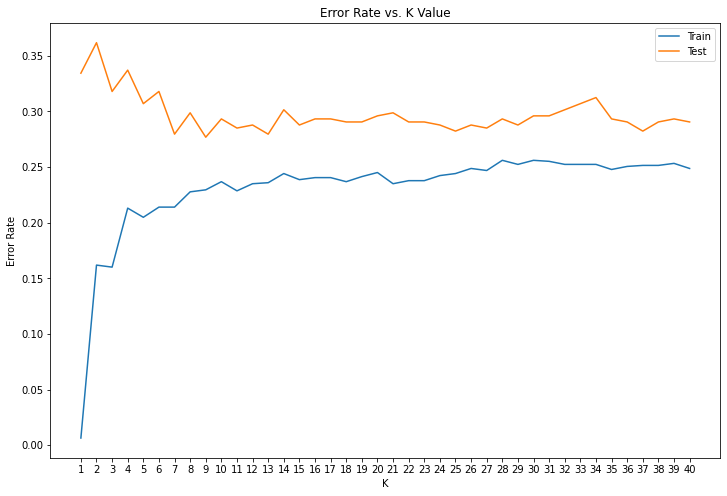

In [71]:
error_rate_train = []
error_rate_test = []

for i in range(1, 41):
 
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)

    pred_train = knn.predict(x_train)
    pred_test = knn.predict(x_test)

    error_rate_train.append(np.mean(pred_train != y_train))
    error_rate_test.append(np.mean(pred_test != y_test))

plt.figure(figsize=(12,8))
plt.plot(range(1,41), error_rate_train, label="Train")
plt.plot(range(1,41), error_rate_test, label='Test')
plt.legend()
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.xticks([i for i in range(1, 41)])
plt.show()

We will use k = 9.

In [72]:
classifier = KNeighborsClassifier(n_neighbors=9)
classifier.fit(x_train, y_train)

pred = classifier.predict(x_test)

print(metrics.classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       188
           1       0.74      0.66      0.70       177

    accuracy                           0.72       365
   macro avg       0.73      0.72      0.72       365
weighted avg       0.72      0.72      0.72       365



# Final considerations and next steps

This simple project has as objective the constrution of Kaplan-Meier curve for patients with cancer. Furthermore, was constructed the classifier for predict if patient will be died or not based in three characteristics:

1. Time,
2. Tumor stage,
3. Age.

The classifier have 74% of precision and 66% of recall in test data.

The next step in this project is use others variables for construct other Kaplan-Meier survival curves and get more informations about the survival probabilities of patients with cancer.